In [16]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Parameter Tuning for Diffuser Problem

## Computational Mesh

In [17]:
# Create Meshes for Diffuser Problem
n_elem_for_width = 32
n_elem_for_height = 33

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model
### Boundary Conditions

In [18]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [19]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [20]:
viscosity = 1.0
density = 1.0

### Finite Element Model

In [21]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon=8.e-2)
fem.set_boudary_values_v(boundary_values_v)

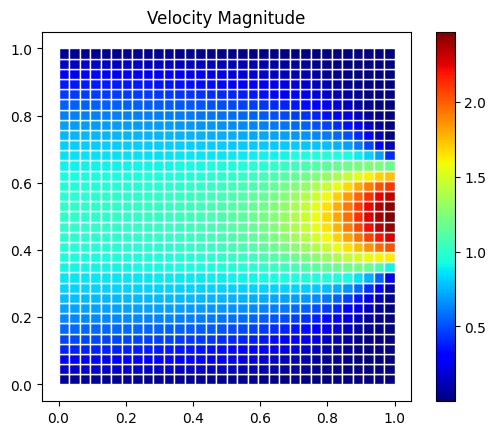

In [22]:
U, u_e, v_e, p_e, F, f = fem.solve()
fem.plot_velocity_magnitude([u_e, v_e])

## Optimization

In [23]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
level_set_scaled_initial = np.ones(mesh_v.n_elem) # Initial scaled level-set function, i.e., design variable, for each element.

In [24]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True


annealing_solver = AnnealingSolver(client)

In [25]:
# Topology Optimization Problem
n_qubits_per_variable = 9
hyperparameters = {
    'energy_dissipation': 500.,
    'regularization': 10.,
    'volume_constraint': 160.,
    'char_func': 25.,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

In [26]:
# Annealing-Based Optimizer (Two-Step Optimization)
annealing_optimizer = Annealing(fem)
max_opt_steps = 3

{'energy_dissipation': 0, 'regularization': 0, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.6451020033749034, Volume Fraction: 0.5, Inconsistencies: 0
Iteration: 1, Objective Function: 0.6221252659867724, Volume Fraction: 0.5, Inconsistencies: 0
Iteration: 2, Objective Function: 0.6070976653470219, Volume Fraction: 0.5, Inconsistencies: 0


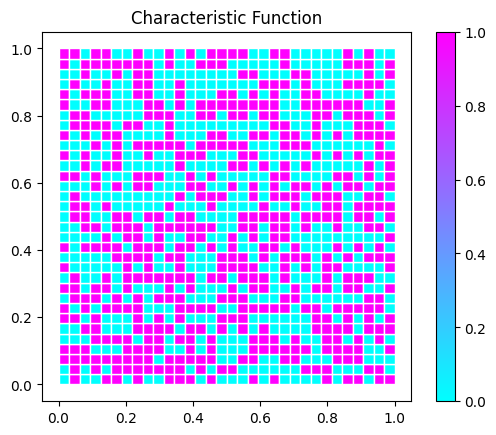

{'energy_dissipation': 0, 'regularization': 10, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.6129512236912538, Volume Fraction: 0.4996843434343436, Inconsistencies: 119
Iteration: 1, Objective Function: 0.6168481916394633, Volume Fraction: 0.5022095959595962, Inconsistencies: 119
Iteration: 2, Objective Function: 0.6437325902389665, Volume Fraction: 0.494528619528618, Inconsistencies: 135


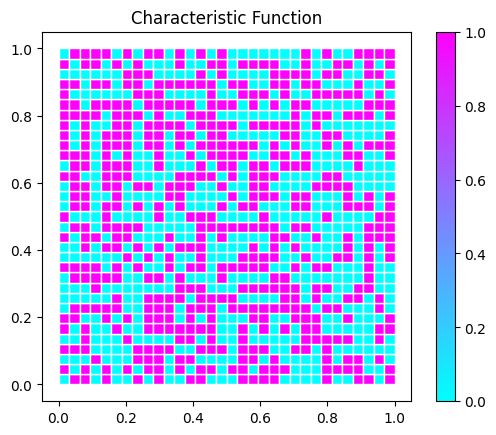

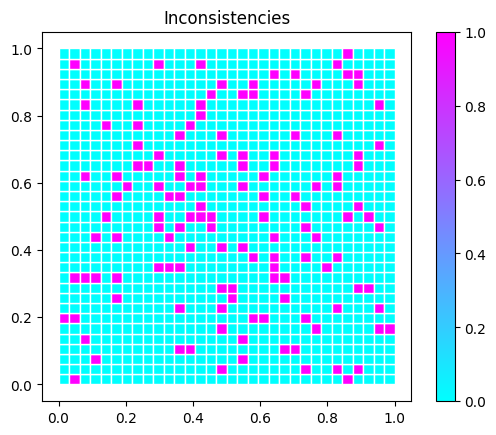

{'energy_dissipation': 0, 'regularization': 20, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.5689574510702655, Volume Fraction: 0.4964225589225593, Inconsistencies: 133
Iteration: 1, Objective Function: 0.563651960339974, Volume Fraction: 0.5044191919191926, Inconsistencies: 167
Iteration: 2, Objective Function: 0.6268144807493584, Volume Fraction: 0.49968434343434404, Inconsistencies: 229


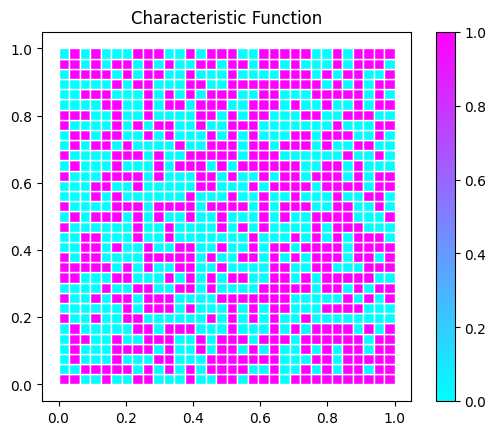

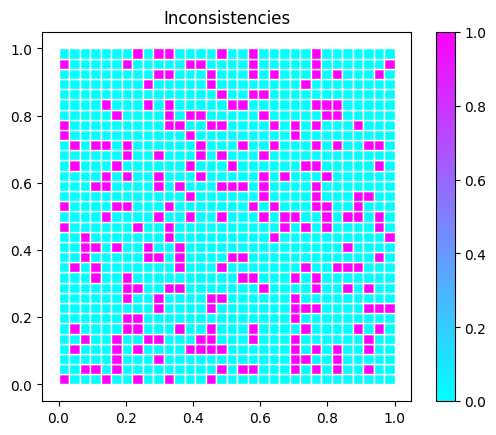

{'energy_dissipation': 0, 'regularization': 30, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.6447848711362892, Volume Fraction: 0.5044191919191939, Inconsistencies: 268
Iteration: 1, Objective Function: 0.5752105425869982, Volume Fraction: 0.4956860269360278, Inconsistencies: 249
Iteration: 2, Objective Function: 0.6158616424183775, Volume Fraction: 0.4895833333333349, Inconsistencies: 267


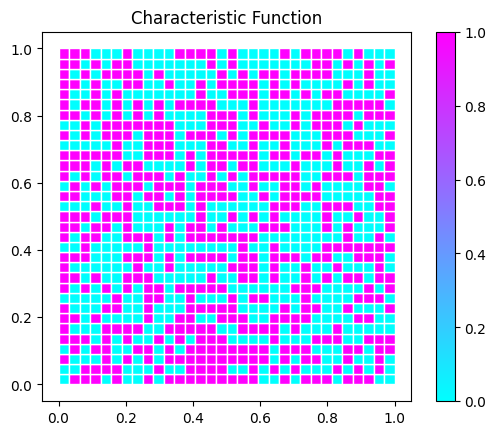

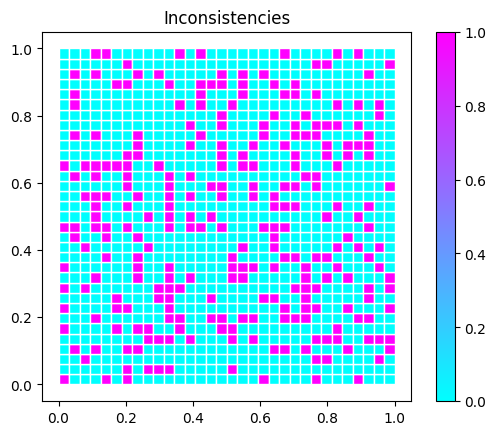

{'energy_dissipation': 0, 'regularization': 40, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.6460865147377709, Volume Fraction: 0.505576599326598, Inconsistencies: 379
Iteration: 1, Objective Function: 0.6481737735478732, Volume Fraction: 0.5081018518518498, Inconsistencies: 353
Iteration: 2, Objective Function: 0.6559964893153116, Volume Fraction: 0.49568602693602815, Inconsistencies: 319


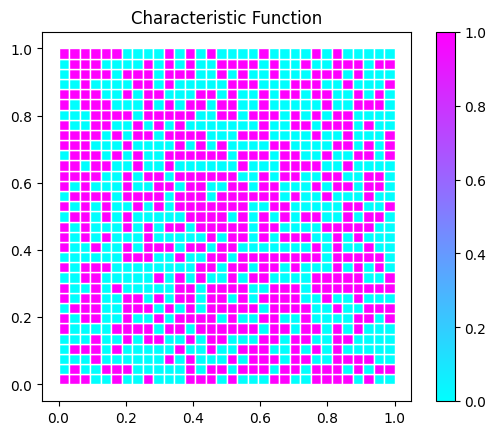

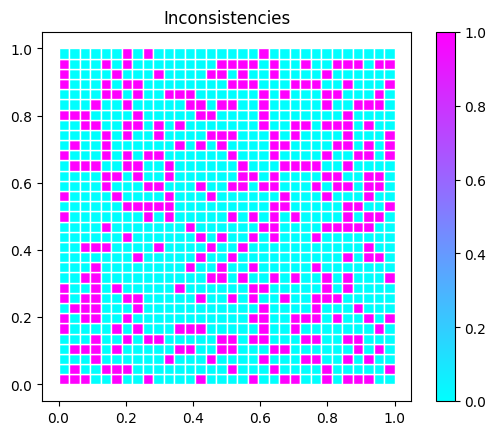

{'energy_dissipation': 500, 'regularization': 0, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.024154498823442262, Volume Fraction: 0.5085227272727273, Inconsistencies: 0
Iteration: 1, Objective Function: 0.012371199425952948, Volume Fraction: 0.5009469696969697, Inconsistencies: 0
Iteration: 2, Objective Function: 0.010058055856927896, Volume Fraction: 0.5, Inconsistencies: 0


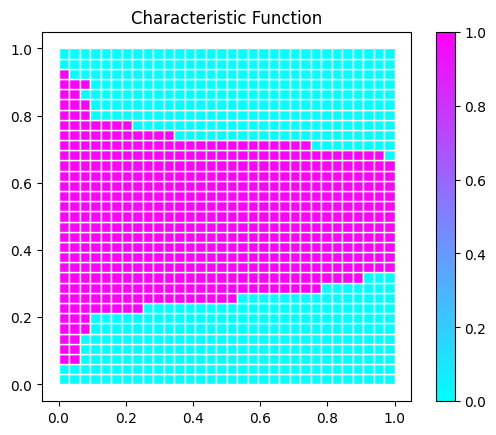

{'energy_dissipation': 500, 'regularization': 10, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.025254250424654293, Volume Fraction: 0.49505471380471366, Inconsistencies: 0
Iteration: 1, Objective Function: 0.012194953503758389, Volume Fraction: 0.49810606060606005, Inconsistencies: 0
Iteration: 2, Objective Function: 0.01212688879783242, Volume Fraction: 0.5041035353535355, Inconsistencies: 0


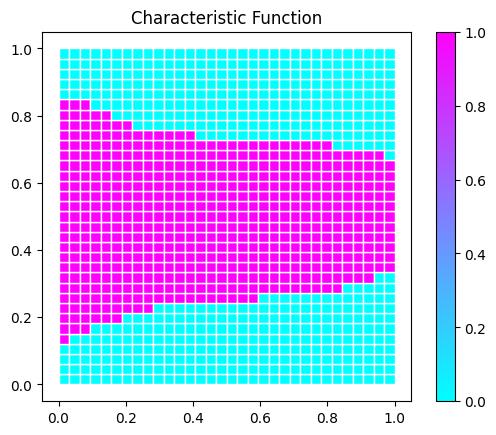

{'energy_dissipation': 500, 'regularization': 20, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.024223125322857877, Volume Fraction: 0.48937289562289354, Inconsistencies: 4
Iteration: 1, Objective Function: 0.015703105500169783, Volume Fraction: 0.4925294612794594, Inconsistencies: 4
Iteration: 2, Objective Function: 0.01422756567364157, Volume Fraction: 0.4970538720538707, Inconsistencies: 5


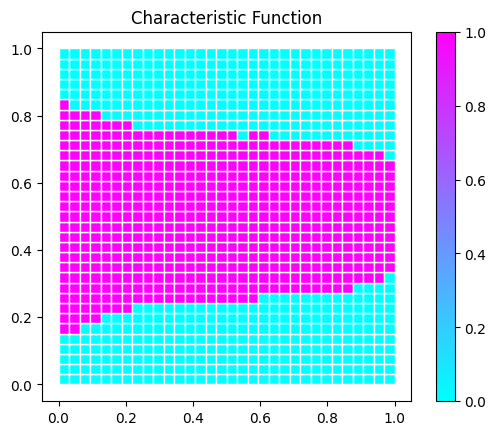

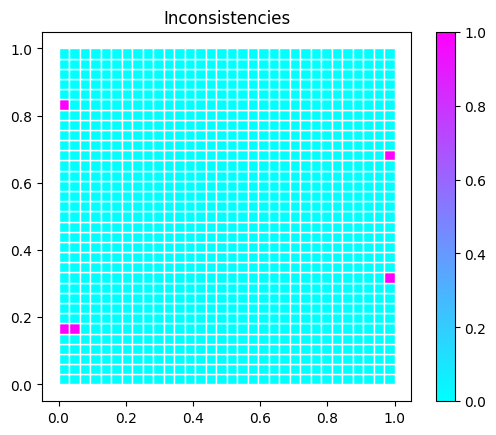

{'energy_dissipation': 500, 'regularization': 30, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.0260956036764318, Volume Fraction: 0.5162037037037017, Inconsistencies: 3
Iteration: 1, Objective Function: 0.01601334698471854, Volume Fraction: 0.5165193602693585, Inconsistencies: 3
Iteration: 2, Objective Function: 0.016054829412405637, Volume Fraction: 0.5125210437710418, Inconsistencies: 3


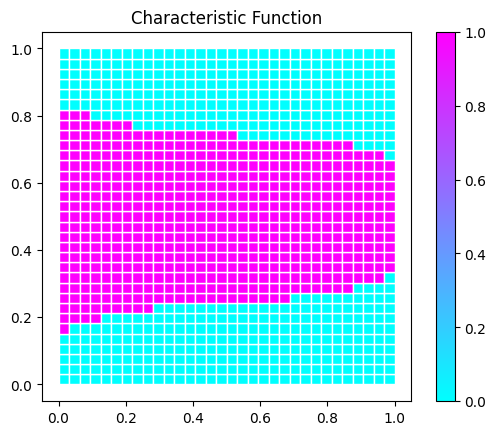

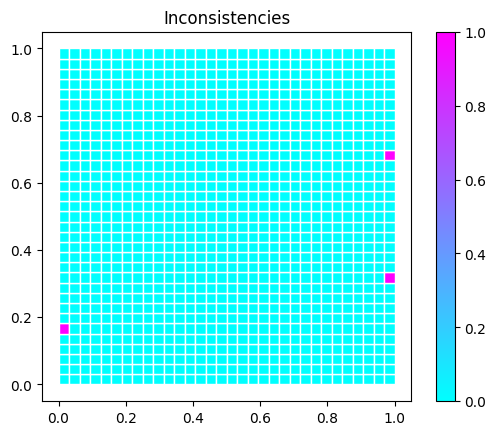

{'energy_dissipation': 500, 'regularization': 40, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.02535664587485382, Volume Fraction: 0.4901094276094289, Inconsistencies: 18
Iteration: 1, Objective Function: 0.02088535334852057, Volume Fraction: 0.5115740740740727, Inconsistencies: 14
Iteration: 2, Objective Function: 0.0178661092200019, Volume Fraction: 0.5042087542087538, Inconsistencies: 14


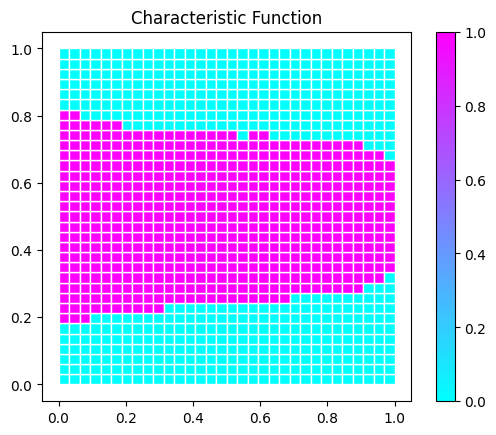

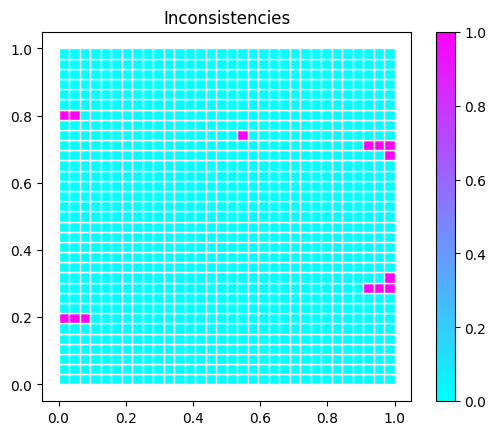

{'energy_dissipation': 1000, 'regularization': 0, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.023084148093045723, Volume Fraction: 0.5170454545454546, Inconsistencies: 0
Iteration: 1, Objective Function: 0.01171916910790664, Volume Fraction: 0.5018939393939394, Inconsistencies: 0
Iteration: 2, Objective Function: 0.01049031007862122, Volume Fraction: 0.5009469696969697, Inconsistencies: 0


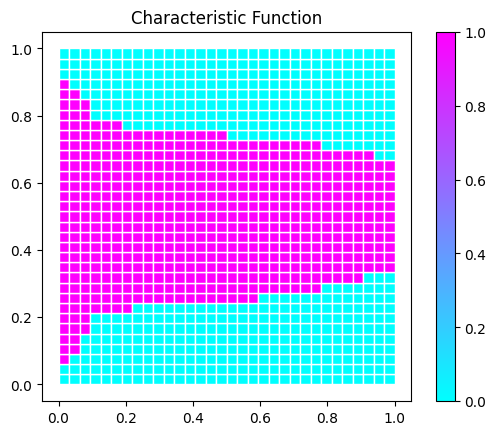

{'energy_dissipation': 1000, 'regularization': 10, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.023084148093045723, Volume Fraction: 0.5041035353535355, Inconsistencies: 1
Iteration: 1, Objective Function: 0.012138265061567581, Volume Fraction: 0.5031565656565652, Inconsistencies: 0
Iteration: 2, Objective Function: 0.011448771111096342, Volume Fraction: 0.5064183501683501, Inconsistencies: 0


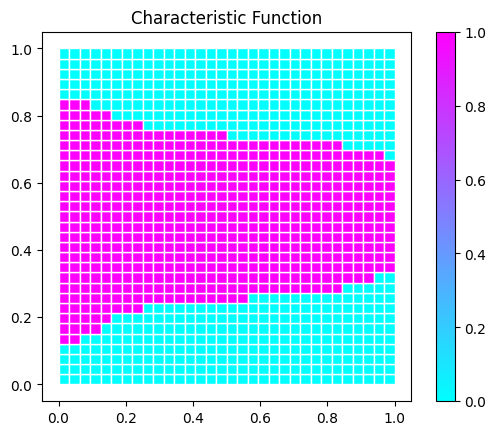

{'energy_dissipation': 1000, 'regularization': 20, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.023084148093045723, Volume Fraction: 0.5130471380471379, Inconsistencies: 3
Iteration: 1, Objective Function: 0.014063212117824235, Volume Fraction: 0.5096801346801346, Inconsistencies: 5
Iteration: 2, Objective Function: 0.01292838132255618, Volume Fraction: 0.503051346801345, Inconsistencies: 4


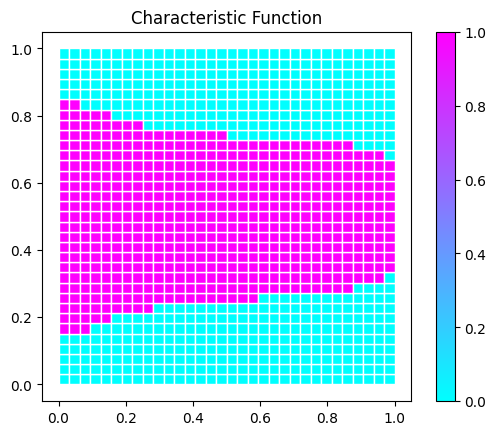

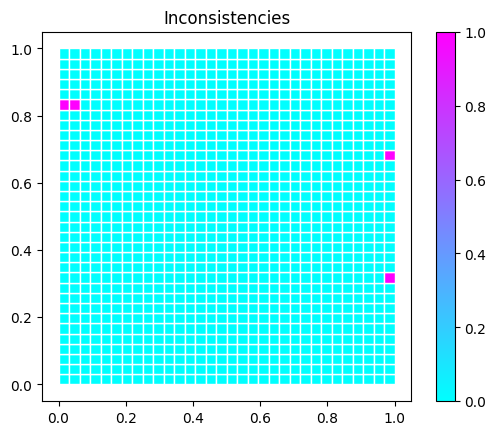

{'energy_dissipation': 1000, 'regularization': 30, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.023084148093045723, Volume Fraction: 0.5172558922558903, Inconsistencies: 3
Iteration: 1, Objective Function: 0.016049754319037345, Volume Fraction: 0.5213594276094262, Inconsistencies: 3
Iteration: 2, Objective Function: 0.01586697664205404, Volume Fraction: 0.5173611111111092, Inconsistencies: 3


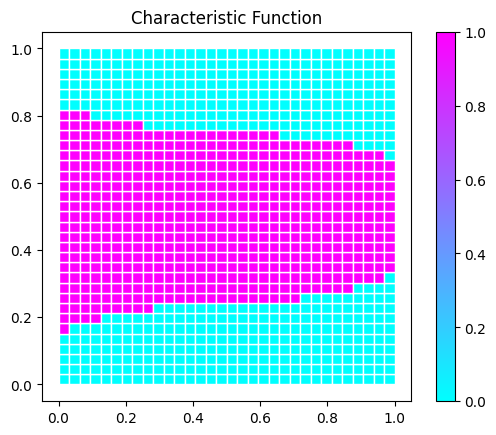

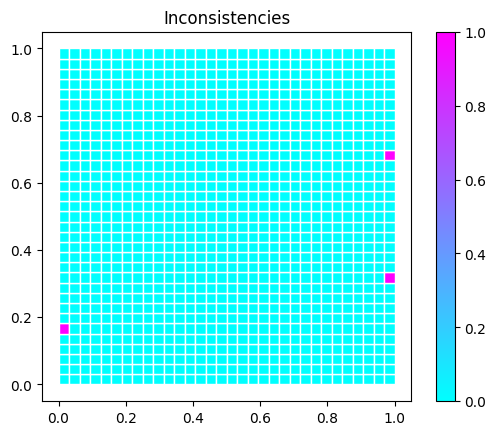

{'energy_dissipation': 1000, 'regularization': 40, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.023084148093045723, Volume Fraction: 0.5107323232323223, Inconsistencies: 3
Iteration: 1, Objective Function: 0.017593036601766546, Volume Fraction: 0.5121001683501671, Inconsistencies: 13
Iteration: 2, Objective Function: 0.01593997352850652, Volume Fraction: 0.5043139730639725, Inconsistencies: 13


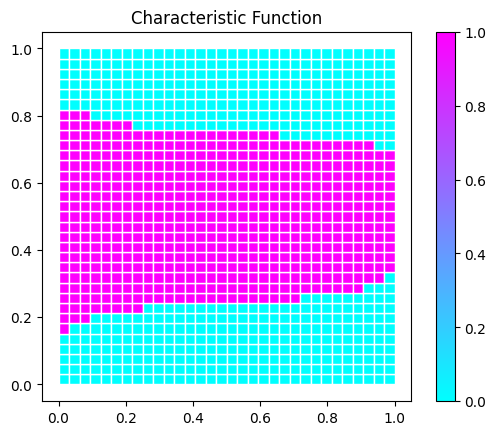

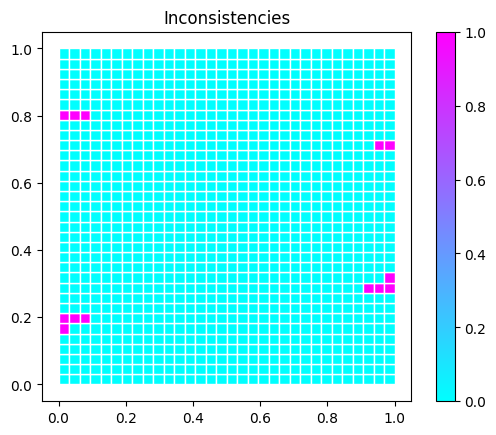

{'energy_dissipation': 1500, 'regularization': 0, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.02294135232208414, Volume Fraction: 0.5236742424242424, Inconsistencies: 0
Iteration: 1, Objective Function: 0.011658668798787221, Volume Fraction: 0.5037878787878788, Inconsistencies: 0
Iteration: 2, Objective Function: 0.010742530527589642, Volume Fraction: 0.5018939393939394, Inconsistencies: 0


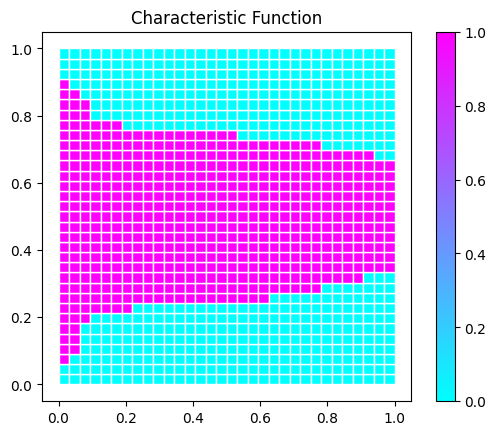

{'energy_dissipation': 1500, 'regularization': 10, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.02294135232208414, Volume Fraction: 0.5079966329966333, Inconsistencies: 1
Iteration: 1, Objective Function: 0.011932942237076711, Volume Fraction: 0.5078914141414143, Inconsistencies: 0
Iteration: 2, Objective Function: 0.011295401119872713, Volume Fraction: 0.5047348484848483, Inconsistencies: 0


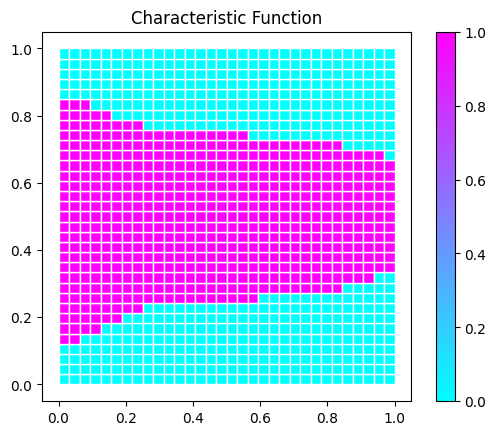

{'energy_dissipation': 1500, 'regularization': 20, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.02294135232208414, Volume Fraction: 0.5198863636363636, Inconsistencies: 3
Iteration: 1, Objective Function: 0.013221609601406125, Volume Fraction: 0.5103114478114469, Inconsistencies: 6
Iteration: 2, Objective Function: 0.012776341123667477, Volume Fraction: 0.5079966329966321, Inconsistencies: 4


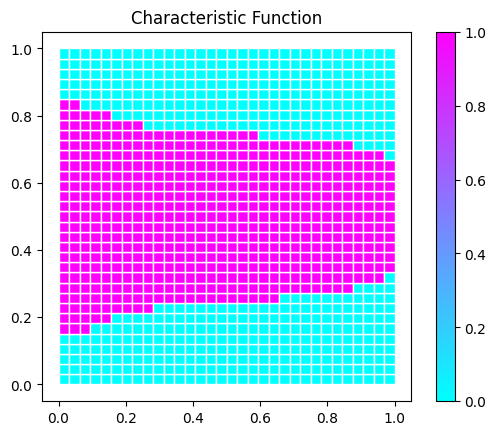

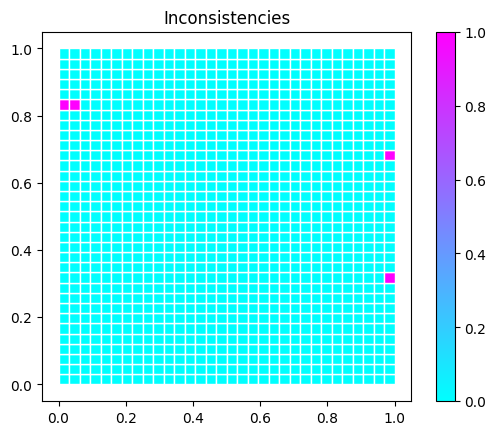

{'energy_dissipation': 1500, 'regularization': 30, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.02294135232208414, Volume Fraction: 0.5252525252525237, Inconsistencies: 3
Iteration: 1, Objective Function: 0.015721662898140754, Volume Fraction: 0.5209385521885503, Inconsistencies: 3
Iteration: 2, Objective Function: 0.013844574382500552, Volume Fraction: 0.514625420875419, Inconsistencies: 5


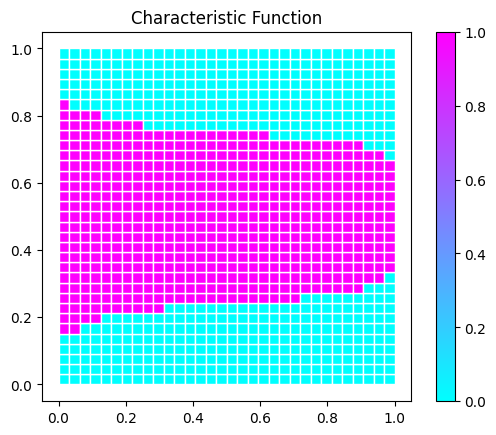

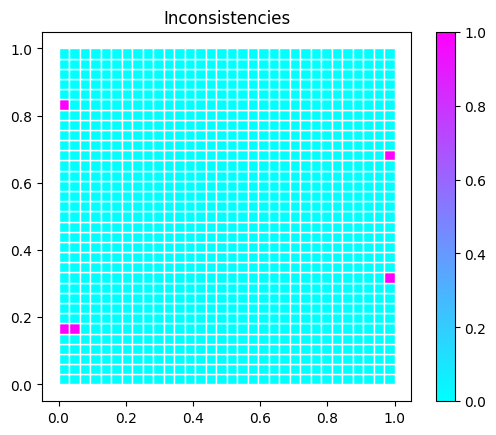

{'energy_dissipation': 1500, 'regularization': 40, 'volume_constraint': 160.0, 'char_func': 25.0}
Iteration: 0, Objective Function: 0.02294135232208414, Volume Fraction: 0.5250420875420863, Inconsistencies: 11
Iteration: 1, Objective Function: 0.01566440772952562, Volume Fraction: 0.5156776094276082, Inconsistencies: 12
Iteration: 2, Objective Function: 0.015601772025513124, Volume Fraction: 0.5069444444444436, Inconsistencies: 10


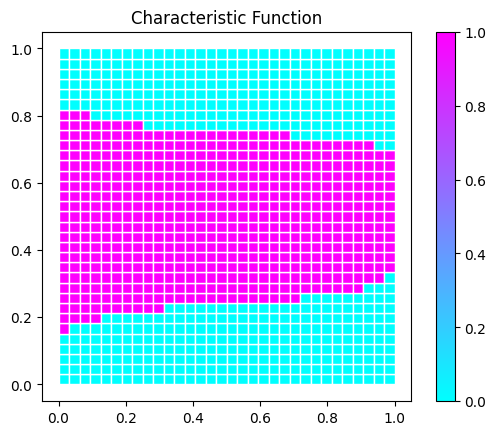

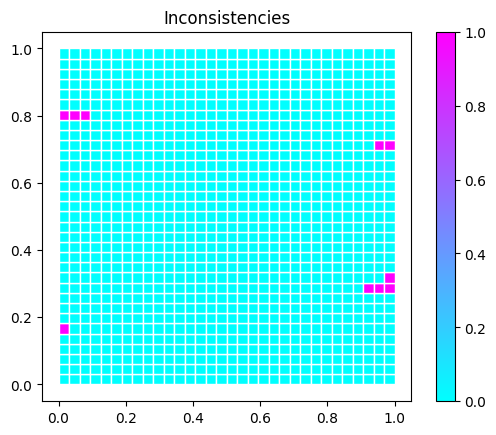

In [27]:
# Hyperparameter Study.

# Energy Dissipation.
lambda_dis_delta = 500#
n_steps_energy_dissipation = 4
# Regularization
lambda_reg_delta = 10
n_steps_regularization = 5

objective_functions_values = []
volume_fraction_values = []
inconsistency_values = []
char_funcs = []

for lambda_dis_i in range(n_steps_energy_dissipation):
    hyperparameters['energy_dissipation'] = lambda_dis_i * lambda_dis_delta
    for lambda_reg_i in range(n_steps_regularization):
        hyperparameters['regularization'] = lambda_reg_i * lambda_reg_delta
        topo_opt_problem.set_hyperparameters(hyperparameters)
        print(topo_opt_problem.hyperparameters)
        annealing_optimizer.optimize(annealing_solver, 
                                    topo_opt_problem,
                                    level_set_scaled_initial, 
                                    max_opt_steps, tol=1e-2)
        objective_functions_values.append(annealing_optimizer.objective_function)
        volume_fraction_values.append(annealing_optimizer.volume_fraction)
        inconsistency_values.append(annealing_optimizer.n_inconsistencies)
        level_set, level_set_scaled, char_func = topo_opt_problem.get_functions_from_binary_solutions(annealing_optimizer.binary_solutions_optimum)
        char_funcs.append(char_func)



In [28]:
def plot_quantity(values, title, x_label, y_label):
    n_x, n_y = values.shape
    
    plt.imshow(values,cmap='jet')
    ax=plt.gca()
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_xticks(np.arange(0, n_x, 1))
    ax.set_xticks(np.arange(-.5, n_x, 1), minor=True)
    ax.set_ylabel(y_label)
    ax.set_yticks(np.arange(0, n_y, 1))
    ax.set_yticks(np.arange(-.5, n_y, 1), minor=True)
    ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)
    plt.colorbar()
    plt.tick_params(bottom=False,left=False,right=False,top=False)
    plt.show()

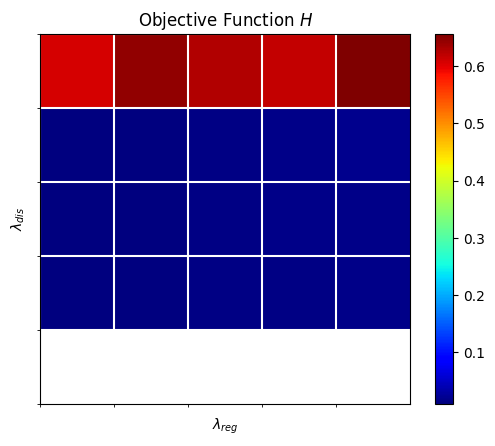

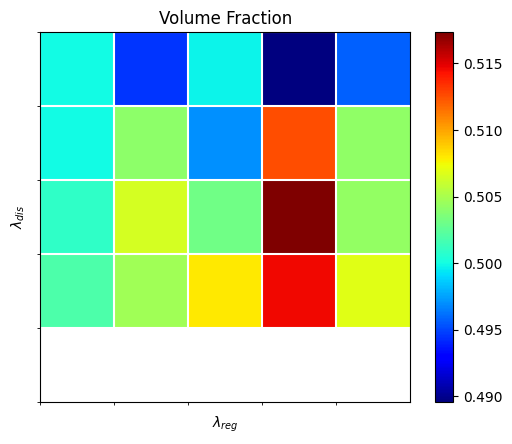

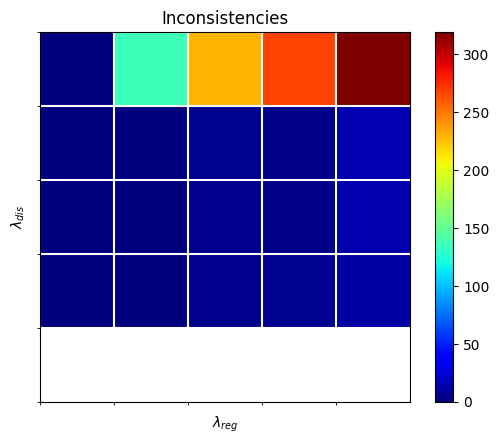

In [31]:
x_label = r'$\lambda_{reg}$'; y_label = r'$\lambda_{dis}$'

# Objective Function H.
objective_functions_values = np.array(objective_functions_values).reshape(n_steps_energy_dissipation, n_steps_regularization)
title = r'Objective Function $H$'
plot_quantity(objective_functions_values, title, x_label, y_label)
# Volume Fraction.
volume_fraction_values = np.array(volume_fraction_values).reshape(n_steps_energy_dissipation, n_steps_regularization)
title = r'Volume Fraction'
plot_quantity(volume_fraction_values, title, x_label, y_label)
# Inconsistencies.
inconsistency_values = np.array(inconsistency_values).reshape(n_steps_energy_dissipation, n_steps_regularization)
title = r'Inconsistencies'
plot_quantity(inconsistency_values, title, x_label, y_label)


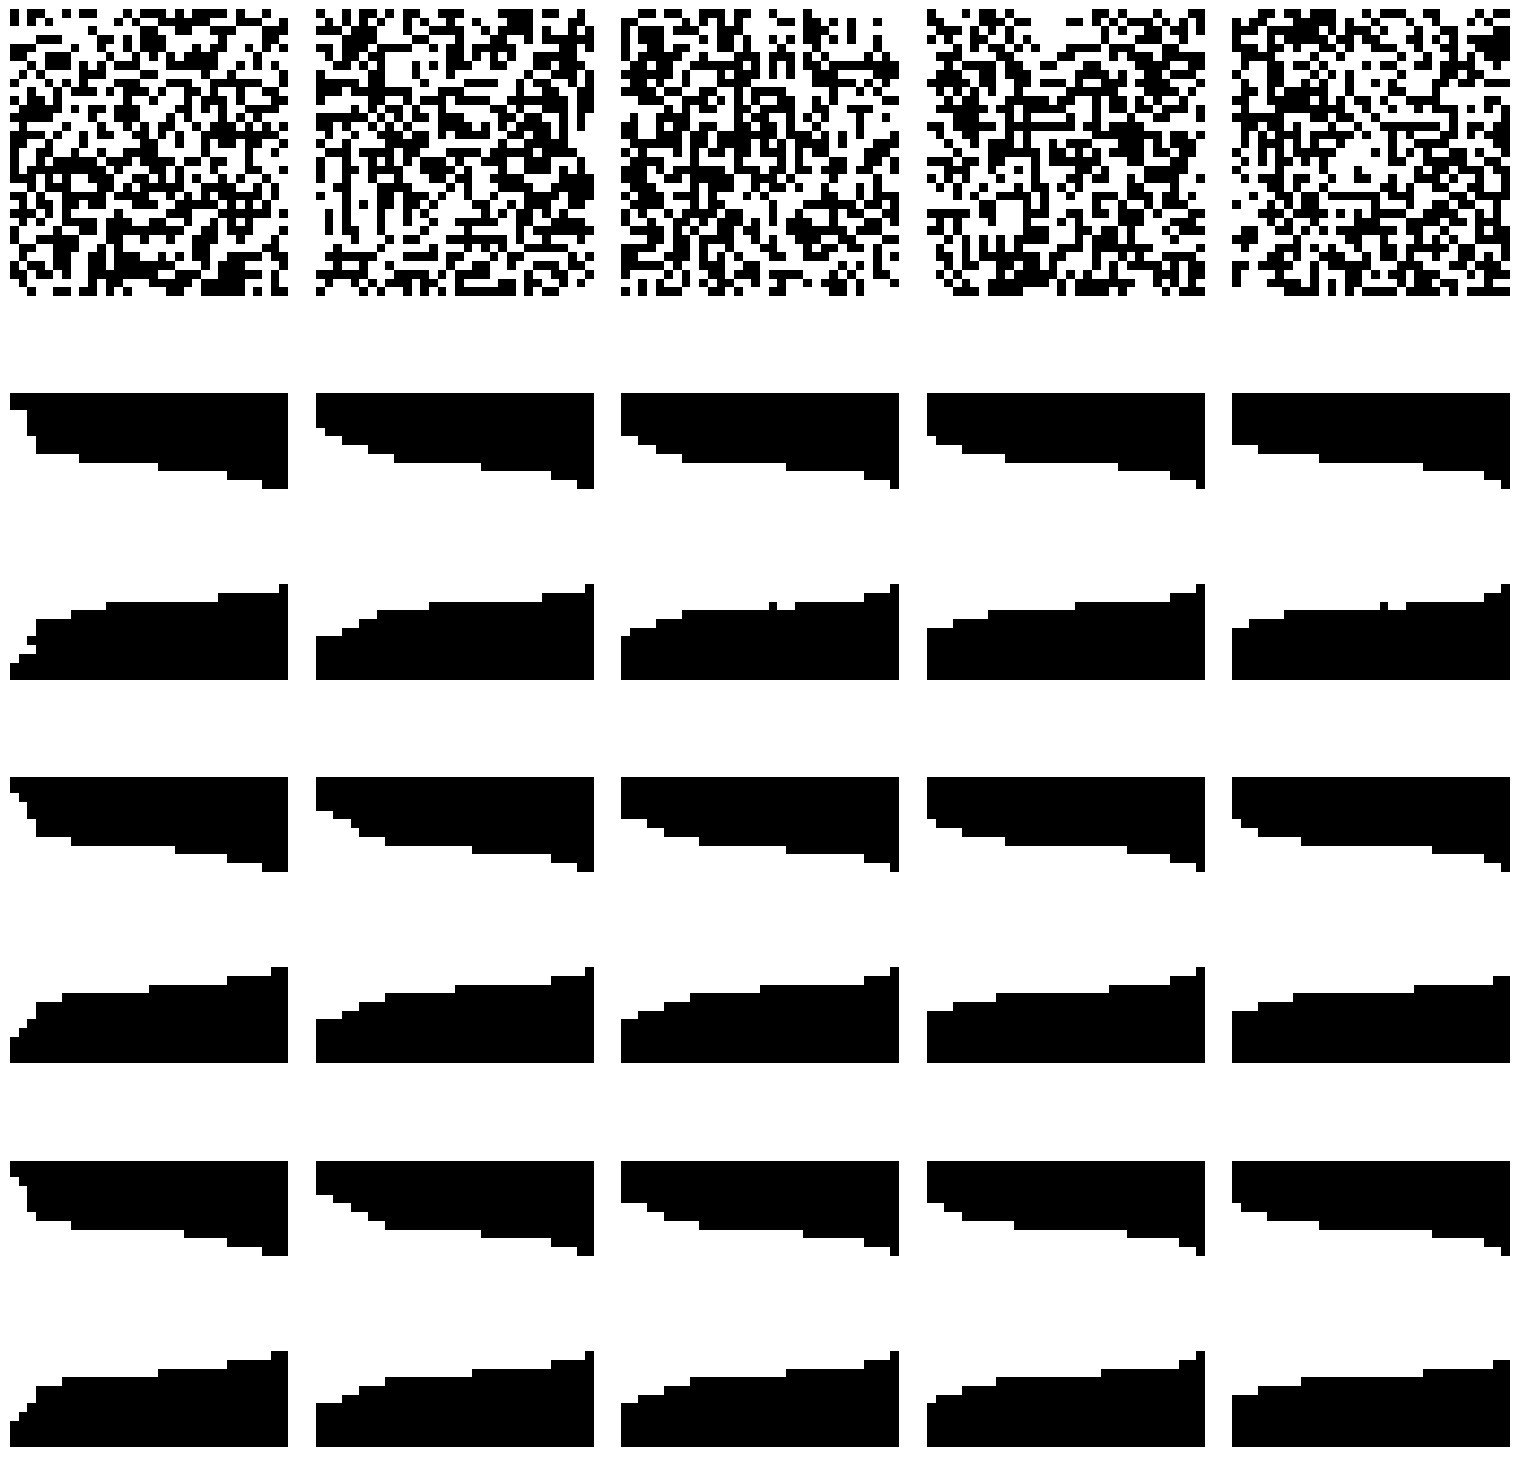

In [30]:
fig, axs = plt.subplots(n_steps_energy_dissipation, n_steps_regularization, figsize=(15, 15))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for lambda_dis_i in range(n_steps_energy_dissipation):
    for lambda_reg_i in range(n_steps_regularization):
        i = lambda_dis_i * n_steps_regularization + lambda_reg_i
        axs[lambda_dis_i][lambda_reg_i].imshow(char_funcs[i].reshape(n_elem_for_width,n_elem_for_height).T,cmap='gray')
        axs[lambda_dis_i][lambda_reg_i].tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        axs[lambda_dis_i][lambda_reg_i].tick_params(bottom=False,left=False,right=False,top=False)
        axs[lambda_dis_i][lambda_reg_i].spines['right'].set_visible(False)
        axs[lambda_dis_i][lambda_reg_i].spines['top'].set_visible(False)
        axs[lambda_dis_i][lambda_reg_i].spines['bottom'].set_visible(False)
        axs[lambda_dis_i][lambda_reg_i].spines['left'].set_visible(False)
plt.show()